# Deep Learning Major Task
## CNN Leaf Classification

### Description:

### First lets write our imports

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

<h1>Part I: Data Preparation </h1>
<h2>Taking a look at the data</h2>
<h3>Describing the data</h3>

In [9]:
# Load the training set (replace 'train.csv' with the actual file name)
train_df = pd.read_csv(r'.\data_files\train.csv')

# Display the first ten rows of the training set
print("#----> First ten rows of the training set:\n", train_df.head(10))

# Get basic description of the training set
print("----> training set description:\n", train_df.describe())

# Get basic information of the training set
print("----> training set information:\n", train_df.info())

#----> First ten rows of the training set:
    id                species   margin1   margin2   margin3   margin4  \
0   1            Acer_Opalus  0.007812  0.023438  0.023438  0.003906   
1   2  Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625   
2   3   Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812   
3   5        Tilia_Tomentosa  0.000000  0.003906  0.023438  0.005859   
4   6     Quercus_Variabilis  0.005859  0.003906  0.048828  0.009766   
5   8   Magnolia_Salicifolia  0.070312  0.093750  0.033203  0.001953   
6  10    Quercus_Canariensis  0.021484  0.031250  0.017578  0.009766   
7  11          Quercus_Rubra  0.000000  0.000000  0.037109  0.050781   
8  14        Quercus_Brantii  0.005859  0.001953  0.033203  0.015625   
9  15         Salix_Fragilis  0.000000  0.000000  0.009766  0.037109   

    margin5   margin6   margin7  margin8  ...  texture55  texture56  \
0  0.011719  0.009766  0.027344      0.0  ...   0.007812   0.000000   
1  0.025391  0.001953

<h3>Cleaning the data</h3>

Check for missing and duplicate values

In [10]:
# Check for missing values
print("Missing values: ", train_df.isnull().sum())

# Check for duplicates
print("Duplicate values: ", train_df.duplicated().sum())


Missing values:  id           0
species      0
margin1      0
margin2      0
margin3      0
            ..
texture60    0
texture61    0
texture62    0
texture63    0
texture64    0
Length: 194, dtype: int64
Duplicate values:  0


----> Looks like we don't have any missing or duplicate values

<h3>Visualizing the data</h3>

Let's display some leaf images from the training set

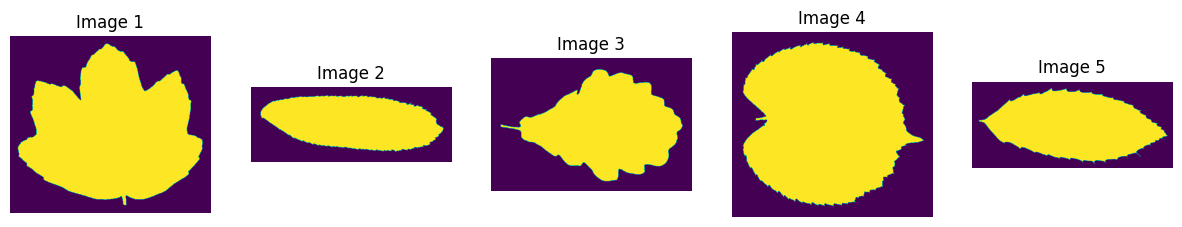

In [17]:
from PIL import Image
import os

image_dir = '.\data_files\images'
image_ids = train_df['id'].head(5).tolist() 

plt.figure(figsize=(15, 8))

for i, image_id in enumerate(image_ids, 1):
    image_path = os.path.join(image_dir, f"{image_id}.jpg")
    image = Image.open(image_path)

    plt.subplot(1, 5, i)
    plt.imshow(image)
    plt.title(f"Image {i}")
    plt.axis('off')

plt.show()


<h3>Correleation Analysis </h3>

we are going to calculate the correlation matrix for shape features<br>
we will use heatmap


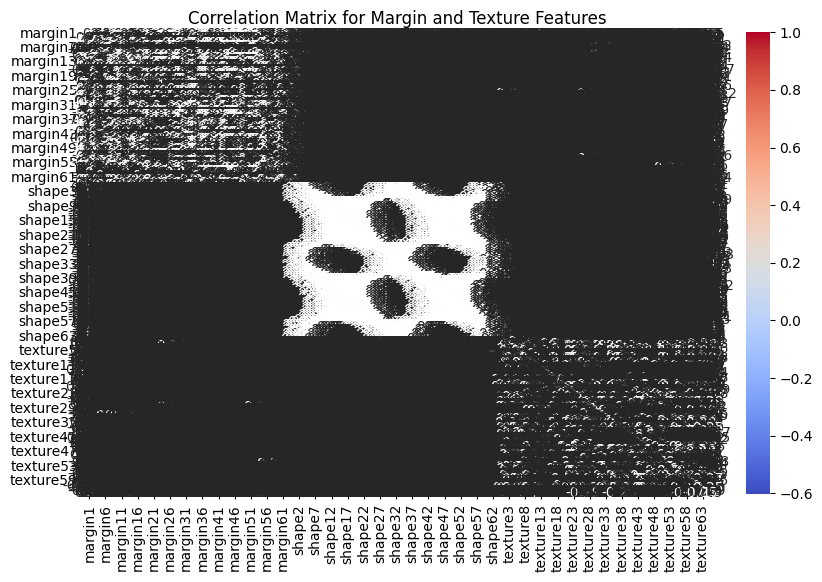

In [20]:
# Extracting columns related to 'margin' and 'texture'
margin_texture_columns = train_df.loc[:, 'margin1':'texture64']

# Calculate correlation matrix for 'margin' and 'texture' features
correlation_matrix_margin_texture = margin_texture_columns.corr()

# Display heatmap for the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_margin_texture, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Margin and Texture Features')
plt.show()


<h2>Train/Test split</h2>

In [24]:
# Define features (X) and target variable (y)
X = train_df.drop(['id', 'species'], axis=1)  # Exclude 'id' and 'species' columns
y = train_df['species']


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h2>Data Standardization</h2>

In [25]:
# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h2>Label Encoding</h2>

<h1>Part II: Training the Neural Network</h1>